In [1]:
%config IPCompleter.greedy=True

In [1]:
import os
import xml.etree.ElementTree as ET
import re
import string
import matplotlib.pyplot as plt
import torch

In [2]:
def rule(line):
    if len(line) == 0: # remove empty line
        return False
    if line[0] == '*': # this char seems to indicate a comment
        return False
    return True

In [3]:
def clean_word(word):
    s = "#/ \n"
    w= word.rstrip(s)
    return w.lstrip(s)

In [4]:
clean_word('\n     /reeff #')

'reeff'

In [5]:
text = '\n\n\n Recorddate:2070-02-24\n'

re.sub(r'[\n]','',text)
text.strip('\n ')


'Recorddate:2070-02-24'

In [6]:
def extract_words(text, tags):
    tag ='O'
    body = {
        'start': 0,
        'end' : 0
    }
    if tags:
        tag, body = tags.pop(0)
    words = []
    word = ''
    for index, char in enumerate(text):
        
        if char == ' ' or char == '\n':
            if word:
                if index > int(body['start']) and index <= (int(body['end']) + 1):
                    words.append((body['TYPE'], clean_word(word)))
                else:
                    words.append(('O', clean_word(word)))
            word = ''
        else:
            word += char
        
        if index > int(body['end']) and tags:
            tag, body = tags.pop(0)
    
    return words
            
        
    

In [7]:
path = './Data'

if not os.path.isdir(path): 
    raise   Exception('Enter valid directory path')

for file in os.listdir(path)[:2]:
    print(file)
    tree = ET.parse(os.path.join(path, file))
    root = tree.getroot()
    print(root.tag)
    
    for child in root:
        print(child.tag)
        if child.tag == 'TEXT':
            text = child.text
            print(len(text))
            print(text[4680:4685])
            l = text.splitlines()
        
        if child.tag == 'TAGS':
            tags = []
            for tag in child:
                tags.append((tag.tag, tag.attrib))
    w = extract_words(text, tags)
    break
    

    


282-01.xml
deIdi2b2
TEXT
4750
62884
TAGS


In [8]:
print(w[:10])

[('O', 'Record'), ('O', 'date:'), ('DATE', '2070-02-24'), ('DATE', 'February'), ('DATE', '24,'), ('DATE', '2070'), ('DOCTOR', 'Leon'), ('DOCTOR', 'F.'), ('DOCTOR', 'Craft,'), ('O', 'M.D.')]


In [67]:
list(filter(lambda i : i[0] != 'O', w))[:300]

[('DATE', '2070-02-24'),
 ('DATE', 'February'),
 ('DATE', '24,'),
 ('DATE', '2070'),
 ('DOCTOR', 'Leon'),
 ('DOCTOR', 'F.'),
 ('DOCTOR', 'Craft,'),
 ('HOSPITAL', 'North'),
 ('HOSPITAL', 'Penn'),
 ('HOSPITAL', 'Hospital'),
 ('STREET', '169'),
 ('STREET', 'Tamworth'),
 ('STREET', 'Place'),
 ('CITY', 'Garnett,'),
 ('STATE', 'CA'),
 ('ZIP', '47749'),
 ('PATIENT', 'Peter'),
 ('PATIENT', 'Joshi'),
 ('MEDICALRECORD', '453-39-84-4'),
 ('DOCTOR', 'Craft:'),
 ('PATIENT', 'Peter'),
 ('PATIENT', 'Joshi'),
 ('DATE', 'February'),
 ('DATE', '24th.'),
 ('PATIENT', 'Joshi'),
 ('PATIENT', 'Joshi'),
 ('PATIENT', 'Peter'),
 ('PATIENT', 'Joshi'),
 ('MEDICALRECORD', '453-39-84-4'),
 ('DATE', '02/24/70'),
 ('DATE', 'December'),
 ('DATE', 'December.'),
 ('PATIENT', 'Joshi'),
 ('PATIENT', 'Joshi'),
 ('PATIENT', 'Joshi'),
 ('PATIENT', 'Peter'),
 ('PATIENT', 'Joshi'),
 ('MEDICALRECORD', '453-39-84-4'),
 ('DATE', '02/24/70'),
 ('DOCTOR', 'John'),
 ('DOCTOR', 'Riggs,'),
 ('DOCTOR', 'quandt'),
 ('DOCTOR', 'Corrine'

### embed the vector and the test

#### target


In [10]:
targets = {
    'DOCTOR': 0,
    'HOSPITAL': 1,
    'MEDICALRECORD': 2,
    'STREET': 3,
    'CITY': 4,
    'STATE': 5,
    'ZIP': 6,
    'DATE': 7,
    'PATIENT': 8,
    'O':9
}
def compute_target(words):
    t = [targets[i[0]] for i in words]
    return torch.eye(len(targets))[t,:]
    

In [11]:
compute_target(w)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [12]:
from flair.embeddings import FlairEmbeddings
from flair.data import Sentence

# init Flair embeddings
flair_forward_embedding = FlairEmbeddings('multi-forward')

In [13]:
flair_forward_embedding.embedding_length

2048

In [14]:
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display
from time import time

In [15]:
def compute_embedding(data, emb):
    '''
        Use a flair embedding to compute the embedding of a list of words
    '''
    tenso = torch.zeros(len(data), emb.embedding_length)
    progress = IntProgress(min=0, max=len(data)) # instantiate the bar
    label = HTML()
    box = VBox(children=[progress, label])
    display(box)
    t0 = time()
    for i in range(len(data)):
        m = max(0,  i -10)
        m2 = min (len(data), i + 11)
        s = Sentence(" ".join(data[m:m2]))
        emb.embed(s)
        tenso[i] = s.tokens[i -m].embedding
        progress.value +=1
        t = time()
        label.value = f'Processing word {i}/{len(data)}, time by word: {t -t0}s'
        t0 = t
    return tenso
        

In [16]:
t = compute_embedding([i[1] for i in w], flair_forward_embedding)

KeyboardInterrupt: 

In [148]:
import pickle as pkl
with open('embedding.pkl', 'wb') as fp:
    pkl.dump(t, fp)

In [72]:
def sentence_maker(words, size, step):
    n = len(words)
    res = []
    ind = 0
    while ind + size <= n:
        res.append(" ".join(words[ind: ind + size]))
        ind = ind + step
    return res
    

In [74]:
s = sentence_maker([i[1] for i in w], 10, 5)
s[:10]

['Record date: 2070-02-24 February 24, 2070 Leon F. Craft, M.D.',
 '2070 Leon F. Craft, M.D. North Penn Hospital 169 Tamworth',
 'North Penn Hospital 169 Tamworth Place Garnett, CA 47749 RE:',
 'Place Garnett, CA 47749 RE: Peter Joshi MR 453-39-84-4 Dear',
 'Peter Joshi MR 453-39-84-4 Dear Dr. Craft: I had the',
 'Dr. Craft: I had the pleasure of meeting Peter Joshi',
 'pleasure of meeting Peter Joshi in the Cardiology Clinic on',
 'in the Cardiology Clinic on February 24th. Mr. Joshi presents',
 'February 24th. Mr. Joshi presents with a complaint of dyspnea',
 'with a complaint of dyspnea and oxygen requirement. The patient']

In [110]:
sent = Sentence(s[5])
flair_forward_embedding.embed(sent)
'''for t in sent:
    print(t, t.embedding)'''

'for t in sent:\n    print(t, t.embedding)'

In [111]:
from sklearn.decomposition import PCA
import numpy as np

In [126]:
sent.tokens[0].embedding.tolist()

2048

In [113]:
data = []
for ind, t in enumerate(sent.tokens):
    data.append(t.embedding.tolist())
data = np.array(data)

In [114]:
pca = PCA(n_components=2)
pca.fit(data)
pdata = pca.transform(data)

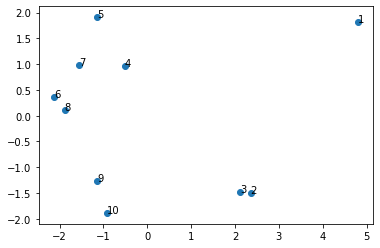

In [117]:
fig, ax = plt.subplots()
z = pdata[:,0]
y = pdata[:,1]
ax.scatter(z, y)

for i, txt in enumerate(range(1, len(z) +1)):
    ax.annotate(txt, (z[i], y[i]))

In [132]:
for t in sent:
    print(t)

Token: 1 Dr.
Token: 2 Craft:
Token: 3 I
Token: 4 had
Token: 5 the
Token: 6 pleasure
Token: 7 of
Token: 8 meeting
Token: 9 Peter
Token: 10 Joshi
